# Intro to Julia

Julia is a high-level programming language like Python and Matlab, but has speeds comparable to C and Fortran. 

In [4]:
exp(im*π) ≈ -1

true

On face value, Julia really looks very similar to Python.

### Package import

In [8]:
using Zygote

### Data simulation

In [9]:
using Distributions

# Define a data generating function
f(x) = sin.(3π*x) + 0.3*cos.(9π*x) + 0.5*sin.(7π * x)

n_points = 500
x = sort(rand(Uniform(-1, 1), n_points))
y = f(x);

### Plotting

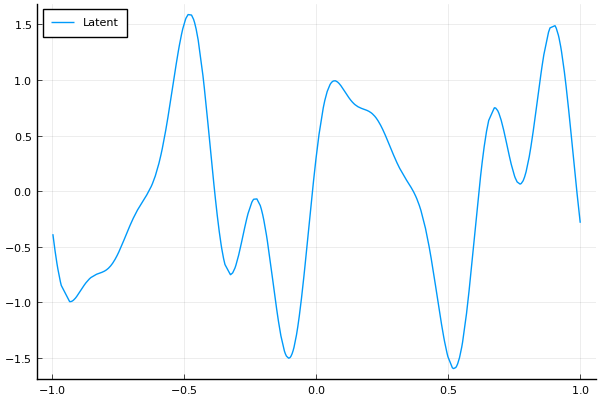

In [12]:
using Plots
pyplot();

p = plot(x, y, label="Latent")

In these slides I will very briefly go over the following as case studies 

* AutoDiff
* Optimisation
* Plotting
* Building applied models

Within all of this, the core differences of Julia vs. R/Python/Matlab will become increasingly apparent.

# Let's now do something useful

## Differentiation

We have a function $y = \sin(3\pi x) + 0.3\cos(9\pi x) + 0.5\sin(7\pi x)$ on $x \in [-1, 1]$, so to find the tangent at $-0.5$ we need to compute the gradient at $-0.5$.

In [13]:
x1 = -0.5

# Compute the derivative
m = f'(x1)
y1 = f(x1)

1.5000000000000002

Now we just need to find the line such that $y-y_{1}=m\left(x-x_{1}\right)$ where $(x_1, y_1) = (-0.5, 1.5)$

In [16]:
tangent(x::AbstractVector; x1::Real, y1::Real, slope::Real) = slope*(x.-x1) .+ y1

tang_x = collect(-0.9:0.01:-0.3)
tang_line = tangent(tang_x; x1=x1, y1=y1, slope=m);

As before, we can layer up a plot of our tangent and the underlying function

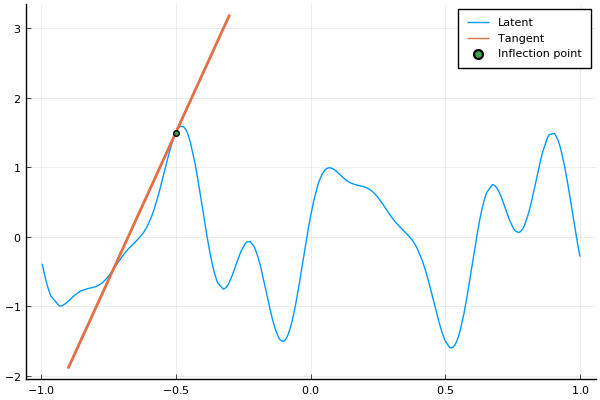

In [17]:
p = plot(x, y, label="Latent")
plot!(tang_x, tang_line, label="Tangent", w=2)
scatter!([x1], [y1], label="Inflection point")

## Gradient Descent

Let's consider a simple minimisation task of the 2D function $$f(\mathbf{x}) = -\exp(\cos(2 x_1 x_2))^2\exp(-x_1^2 - x_2^2).$$

### Define the objective

In [18]:
objective(X::AbstractVector) = -exp(cos(2*X[1]*X[2]))^2*exp(-X[1]^2-X[2]^2)
objective(X::AbstractArray) = [objective(X[i, :]) for i in 1:size(X, 1)]
objective(x::Float64, y::Float64) = objective([x, y])

objective (generic function with 3 methods)

### Visualise the optimisation surface

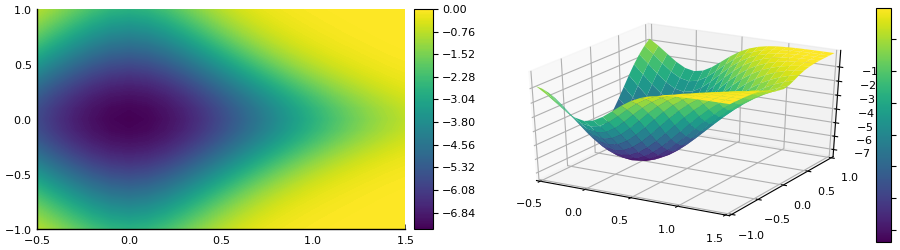

In [19]:
x = -0.5:0.1:1.5
y = -1:0.1:1

X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))

Z = map(objective, X, Y)
p1 = contour(x, y, Z, c=:viridis, fill=true, levels=240)
p2 = surface(x, y, Z, c=:viridis, alpha=0.5)
plot(p1, p2, size=(900, 250))

### Compute gradients 

Gradient descent is simply 
$$\mathbf{x}^{(t+1)} = \mathbf{x}^{(t)} + \frac{\alpha}{t} f'(\mathbf{x}^{(t+1)})$$
so we can use `Zygote` again to compute gradients.

In [21]:
function gradient_descent(starting_vals::AbstractVector, learning_rate::Float64, f::Function; n_iter::Int64=20)
    n_params = size(starting_vals, 1)
    steps = Array{Float64}(undef, n_iter+1, n_params)
    steps[1, :] = starting_vals
    
    for it in 1:n_iter
        steps[it+1, :] = steps[it, :] - (learning_rate/it)*f'(steps[it, :])
    end
    return steps        
end

gradient_descent (generic function with 1 method)

Let's now run gradient descent on our target density.

In [ ]:
α = 1.0
steps = gradient_descent([1.4, 0.9], α, objective; n_iter=15);

p1 = contour(x, y, Z, c=:viridis, fill=true, levels=240);

anim = @animate for i in 1:size(steps, 1)
    lx, ly = steps[i, :]
    if i > 1
        plot!(steps[(i-1):i, 1], steps[(i-1):i, 2], c=:red);
    end
    scatter!([lx], [ly], leg=false, c=:red);
end

We can very easily create a gif now of this image

In [ ]:
gif(anim, "GD.gif", fps=5);

![](GD.gif)

Try now with something more interesting; the Levy3 function, which is known to be particularly challenging in optimisation due to the many modes it features.

In [26]:
function objective(X::AbstractVector)
    w = 1 .+ (X.-1)/4
    sum_term = sum((w .- 1).^2 .* (1 .+ 10*sin.(π*w .+ 1).^2) .+ (w .- 1).^2 .* (1 .+ sin.(2π*w).^2))
    return sin(π*w[1])^2 + sum_term 
end

objective (generic function with 3 methods)

As with before, we can plot our optimisation surface

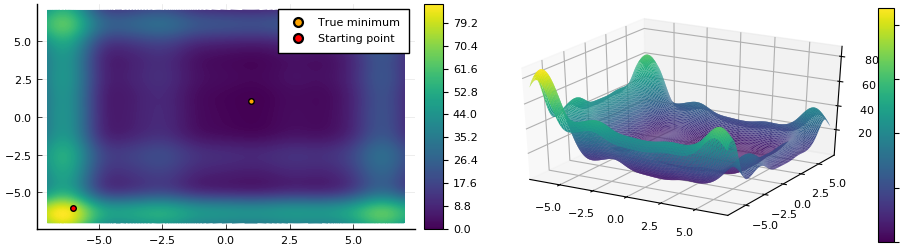

In [32]:
x = -7:0.1:7
y = -7:0.1:7

X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))

Z = map(objective, X, Y)
p1 = contourf(x, y, Z, c=:viridis, levels=240)
scatter!([1], [1], label="True minimum", c=:orange)
scatter!([-6], [-6], label="Starting point", c=:red)
p2 = surface(x, y, Z, c=:viridis, alpha=0.7)
plot(p1, p2, size=(900, 250))

We'll now run gradient descent from our initial, very poor, starting point

In [ ]:
α = 0.4
steps = gradient_descent([-6, -6], α, objective; n_iter=50);

p = contour(x, y, Z, c=:viridis, fill=true, levels=240);
scatter!([1], [1], label="True minimum", c=:orange)

anim = @animate for i in 1:size(steps, 1)
    lx, ly = steps[i, :]
    if i > 1
        plot!(steps[(i-1):i, 1], steps[(i-1):i, 2], c=:red);
    end
    scatter!([lx], [ly], leg=false, c=:red);
end

And create a gif again

In [ ]:
gif(anim, "Levy.gif", fps=5);

![](Levy.gif)

# Overloading

Earlier we defined two plots as `p1` and `p2`. To compose them together into a single plot we used the `plot()` command, however, we could have overloaded the unary `+` operator. This is really useful when adding complex objects together such as kernels.

In [40]:
import Base.+
import Plots.Plot 

function +(x::Plot, y::Plot)
    plot(x, y, size=(900, 250))
end


+ (generic function with 343 methods)

so now we can do `p1+p2` to get the same result as before.

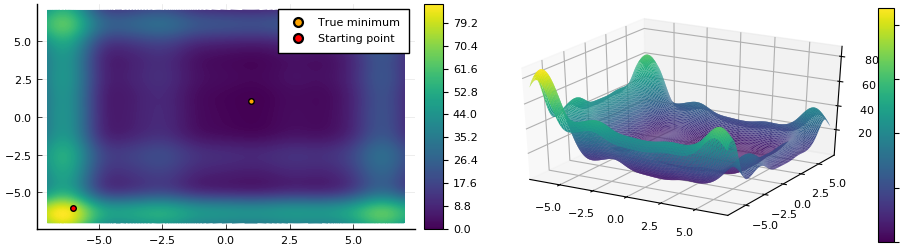

In [41]:
p1 + p2

# Modelling

## Load data

In [ ]:
using GaussianProcesses, DelimitedFiles

data = readdlm("CO2_data.csv",',')
year = data[:,1]; co2 = data[:,2];

## Inspect data

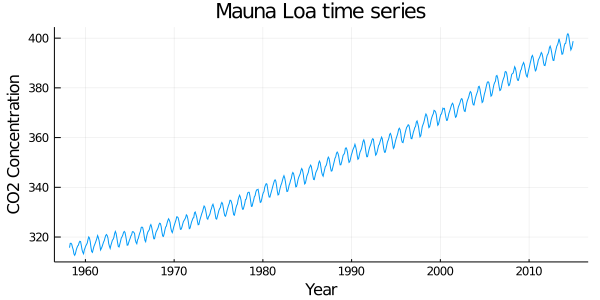

In [5]:
plot(data[:, 1], data[:, 2], leg=false, size=(600, 300))
xlabel!("Year")
ylabel!("CO2 Concentration")
title!("Mauna Loa time series")

## Partition into train/test

In [6]:
xtrain = year[year.<2004]; ytrain = co2[year.<2004];
xtest = year[year.>=2004]; ytest = co2[year.>=2004];

## Define a kernel

We'll define a complex function here where we've overloading the `+` and `*` operators to allow easy kernel combinations.

In [7]:
kernel = SE(4.0,4.0) + Periodic(0.0,1.0,0.0)*SE(4.0,0.0) + RQ(0.0,0.0,-1.0) + SE(-2.0,-2.0);

## Define the GP and fit

We'll now fit the GP to the training data. We're using the `optimize!()` bang function here from the `Optim.jl` package here. Typically, one would have to define the objective function, derivates.etc as we did in the GD example, but through overloading of the `optimize!()` function, we don't have to do this.

In [12]:
gp = GP(xtrain,ytrain,MeanZero(),kernel,-2.0)
optimize!(gp);

## Make predictions on heldout data

We'll compute the predictive mean $\mu$ and predictive variance $\Sigma$ of the GP at the test points, conditional on our training observations.

In [10]:
μ, Σ = predict_y(gp,xtest);

## Plot predictions

We've again overloaded the plot function here to take GP outputs.

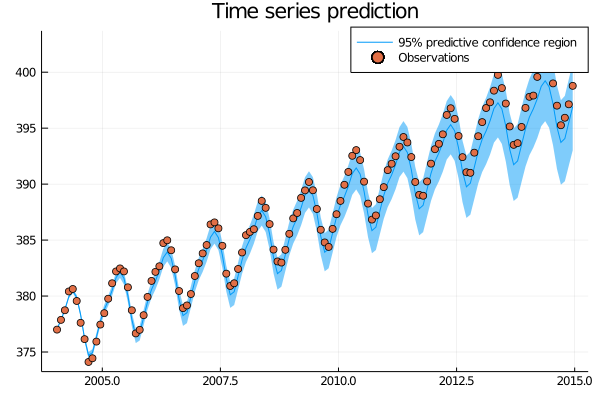

In [11]:
plot(xtest,μ,ribbon=Σ, title="Time series prediction",label="95% predictive confidence region")
scatter!(xtest,ytest,label="Observations")

Thanks for listening!

Slides and notebook can be found at [Add URL here.]()


Julia also has a really mature modelling library through `Turing.jl` for probabilistic model building, and `Flux.jl` for deep learning.

## Bayesian logistic regression example

In [7]:
using Flux
using Flux: logitcrossentropy, normalise, onecold, onehotbatch
using Statistics: mean
using Parameters: @with_kw

## Load data

In [13]:
y = Flux.Data.Iris.labels()
X = Flux.Data.Iris.features()
ndim, nrows = size(X)
print("$nrows $ndim-dimensional observations loaded")

150 4-dimensional observations loaded

## Preprocess

We'll standardise the data, one-hot encode the labels, and finally partition into a train/test split.

### Standardise

In [15]:
normed_X = normalise(X, dims=2);

### One-hot encode

In [28]:
classes = sort(unique(y))
n_classes = length(classes)
onehot_labels = onehotbatch(labels, classes)

3×150 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1

### Partition

In [36]:
train_idx = [1:3:150 ; 2:3:150]

X_train = normed_X[:, train_idx]
y_train = onehot_labels[:, train_idx]

X_test = normed_X[:, 3:3:150]
y_test = onehot_labels[:, 3:3:150]

train_data = Iterators.repeated((X_train, y_train), 100)
test_data = (X_test,y_test);

## Define logistic model

We have 4-dimensional inputs and and 3 distinct classes

In [37]:
model = Chain(Dense(ndim, n_classes))

Chain(Dense(4, 3))

### Loss function and optimiser

In [38]:
loss(x, y) = logitcrossentropy(model(x), y)
optimiser = ADAM(0.1)

ADAM(0.1, (0.9, 0.999), IdDict{Any,Any}())

## Train

In [39]:
Flux.train!(loss, params(model), train_data, optimiser)

## Predict

### Accuracy

In [43]:
accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))

X_test, y_test = test_data
acc = accuracy(X_test, y_test, model)
println("Accuracy: $acc")

Accuracy: 0.92


### Confusion matrix

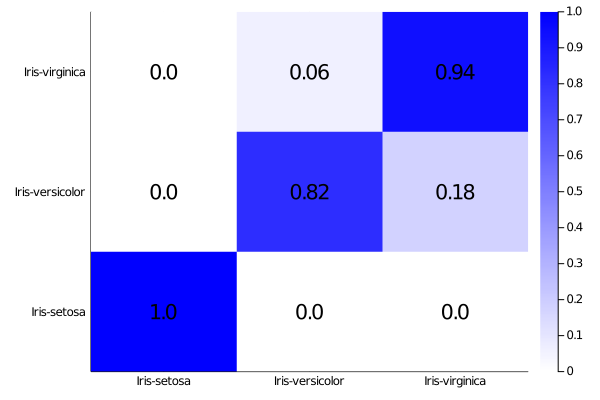

In [153]:
function confusion_matrix(X, y, model)
    ŷ = onehotbatch(onecold(model(X)), 1:3)
    mat = y * transpose(ŷ)
    row_sums = sum(mat, dims=2)
    return mat./row_sums
end

conf_mat = confusion_matrix(X_test, y_test, model)
p = heatmap(classes, classes, conf_mat, c=cgrad([:white, :blue]))
for (idx, val) in enumerate(0.5:1:2.5)
    conf_slice = round.(conf_mat[idx, :], digits=2)
    annotate!(0.5:1:2.5, val, conf_slice)
end
p